# Analyze CGNet Events

## Import libraries

In [1]:
import os
import sys
import numpy as np

sys.path.append("/glade/work/kdagon/ClimateNet") # append path to ClimateNet repo
from climatenet.utils.data import ClimateDatasetLabeled, ClimateDataset
from climatenet.models import CGNet
from climatenet.utils.utils import Config
from climatenet.track_events import track_events
#from climatenet.analyze_events import analyze_events
from climatenet.analyze_events_region import analyze_events # regionally modified script
#from climatenet.visualize_events import visualize_events
from climatenet.visualize_events_region import visualize_events # regionally modified script

from os import path

import xarray as xr
import dask
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature

Can't use a dask cluster this way until I add dask_jobqueue (and distributed?) to conda env

In [ ]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
nmem1 = '10GiB' # PBSCluster specification
nmem2 = '10GB' # pbs specification
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem1, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/derecho/scratch/kdagon/dask-local', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+nmem2, # Specify resources
    account='P06010014', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ext', # Interface to use
)

# Scale up -- how to determine this number?
cluster.scale(10)

# Change your url to the dask dashboard so you can see it
#dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})
#dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/GPU/proxy/{port}/status'}) # need to include name of server if named!
# the above is for jupyterhub only, otherwise use /proxy/{port}/status (also need to launch ssh tunneling from the appropriate environment)
#dask.config.set({'distributed.dashboard.link': "/proxy/{port}/status"})
# really I should set these options in some sort of config file...

# Setup your client
client = Client(cluster)

## Processing Notes
* Testing if the track/analyze scripts can be run on non-global spatial extent masks
  * It works, but some of the plotting assumes global extent so needs modification
* dask is not in cgnet environment so created a new env `cgnet-dask` cloned and then added dask
* cgnet scripts use multiprocessing pool so there is some parallelism there
* Could also put in a large mem cpu request on Jhub casper batch if needed (and/or PBSCluster for notebook workers)
* Do I need GPUs to run the analysis scripts? Doesn't look like they use torch

## Set ClimateNet filepath

In [2]:
cesm_cnet_filepath = "/glade/campaign/cgd/ccr/kdagon/cgnet/" # retrained NCAR model, after data processing workflow was finalized

## Set regional bounds

In [3]:
# Western US/Eastern Pacific domain from ARTMIP
#lat_bounds = slice(25,65)
#lon_bounds = slice(180,255)

# Larger region for genesis/termination plots
lat_bounds = slice(15,65)
lon_bounds = slice(120,255)

### Preprocessing function to subset regionally

In [4]:
def preprocess_region(ds):
    # return regional domain
    return ds['masks'].sel(lat=lat_bounds,lon=lon_bounds)

## CESM historical simulation

In [8]:
hist_yrs = [str(i) for i in range(2000,2006)]
hist_folders = ["B20TRC5CN/"+y+"/masks_unwgt/" for y in hist_yrs] # unweighted means/std

In [9]:
cnet_file = 'class_masks.nc'
hist_paths = [cesm_cnet_filepath+hist_folders[i]+cnet_file for i,f in enumerate(hist_folders)]
hist_paths

['/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2000/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2001/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2002/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2003/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2004/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2005/masks_unwgt/class_masks.nc']

### Read in masks with preprocessing

In [10]:
%%time
cnet_hist_shift = xr.open_mfdataset(hist_paths, concat_dim='time',combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)

CPU times: user 101 ms, sys: 78.2 ms, total: 179 ms
Wall time: 497 ms


In [11]:
cnet_hist_shift

<xarray.DataArray 'masks' (time: 17520, lat: 213, lon: 433)>
dask.array<concatenate, shape=(17520, 213, 433), dtype=int64, chunksize=(500, 213, 433), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 120.0 120.3 120.6 120.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 15.14 15.37 15.61 15.84 ... 64.19 64.42 64.65 64.89
  * time     (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
Attributes:
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    remap_hostname:             crhtc10
    remap_version:              4.7.9
    NCO:                        netCDF Operators version 4.7.9 (Homepage = ht...
    map_file:                   /glade/campaign/cgd/amp/jet/ClimateNet/data_p...
    input_file:                 /glade/campaign/cgd/ccr/jet/nanr_forKatie/3hr...
    np:                         4
    ne:                         120
    case:                       b.e13.B20TRC5CN.ne120_g16.003
    title:                      UNSET
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

### Shift time indices of 2000-2005 back 3hrs to avoid duplicative index
Note that format of datetime matters depending on underlying package versions

In [12]:
timeshift = cnet_hist_shift.sel(time=slice("2000-01-01T03:00:00","2006-01-01T00:00:00")).time.indexes['time'].shift(-3,"H")

In [13]:
timeshift

CFTimeIndex([2000-01-01 00:00:00, 2000-01-01 03:00:00, 2000-01-01 06:00:00,
             2000-01-01 09:00:00, 2000-01-01 12:00:00, 2000-01-01 15:00:00,
             2000-01-01 18:00:00, 2000-01-01 21:00:00, 2000-01-02 00:00:00,
             2000-01-02 03:00:00,
             ...
             2005-12-30 18:00:00, 2005-12-30 21:00:00, 2005-12-31 00:00:00,
             2005-12-31 03:00:00, 2005-12-31 06:00:00, 2005-12-31 09:00:00,
             2005-12-31 12:00:00, 2005-12-31 15:00:00, 2005-12-31 18:00:00,
             2005-12-31 21:00:00],
            dtype='object', length=17520)

In [14]:
cnet_hist = cnet_hist_shift.sel(time=slice("2000-01-01T03:00:00","2006-01-01T00:00:00")).assign_coords(time=timeshift)
cnet_hist

<xarray.DataArray 'masks' (time: 17520, lat: 213, lon: 433)>
dask.array<concatenate, shape=(17520, 213, 433), dtype=int64, chunksize=(500, 213, 433), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 120.0 120.3 120.6 120.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 15.14 15.37 15.61 15.84 ... 64.19 64.42 64.65 64.89
  * time     (time) object 2000-01-01 00:00:00 ... 2005-12-31 21:00:00
Attributes:
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    remap_hostname:             crhtc10
    remap_version:              4.7.9
    NCO:                        netCDF Operators version 4.7.9 (Homepage = ht...
    map_file:                   /glade/campaign/cgd/amp/jet/ClimateNet/data_p...
    input_file:                 /glade/campaign/cgd/ccr/jet/nanr_forKatie/3hr...
    np:                         4
    ne:                         120
    case:                       b.e13.B20TRC5CN.ne120_g16.003
    title:                      UNSET
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

## CESM RCP2.6 simulation

In [15]:
rcp26_yrs = [str(i) for i in range(2006,2015)] # note stopping at 2014 here to match # RCP8.5 yrs
rcp26_folders = ["BRCP26C5CN/"+y+"/masks_unwgt/" for y in rcp26_yrs] # unweighted means/std

In [16]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
rcp26_paths = [cesm_cnet_filepath+rcp26_folders[i]+cnet_file for i,f in enumerate(rcp26_folders)]
rcp26_paths

['/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2006/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2007/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2008/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2009/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2010/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2011/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2012/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2013/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2014/masks_unwgt/class_masks.nc']

### Read in masks with preprocessing

In [17]:
%%time
cnet_rcp26 = xr.open_mfdataset(rcp26_paths, concat_dim='time',combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)

CPU times: user 142 ms, sys: 138 ms, total: 279 ms
Wall time: 626 ms


In [18]:
cnet_rcp26

<xarray.DataArray 'masks' (time: 26280, lat: 213, lon: 433)>
dask.array<concatenate, shape=(26280, 213, 433), dtype=int64, chunksize=(500, 213, 433), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 120.0 120.3 120.6 120.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 15.14 15.37 15.61 15.84 ... 64.19 64.42 64.65 64.89
  * time     (time) object 2006-01-01 00:00:00 ... 2014-12-31 21:00:00
Attributes:
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    np:                         4
    ne:                         120
    case:                       b.e13.BRCP26C5CN.ne120_g16.003
    title:                      UNSET
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               b.e13.B20TRC5CN.ne120_g16.003.cam.i.2006-01-0...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history:                    Mon Apr 03 10:49:05 2023: cdo splitsel,1 2006...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    remap_hostname:             crhtc62
    remap_version:              4.7.9
    NCO:                        netCDF Operators version 4.7.9 (Homepage = ht...
    map_file:                   /glade/p/cgd/amp/jet/mapfiles/map_ne120_to_dl...
    input_file:                 /glade/campaign/cgd/amp/jet/ClimateNet/data_p...
    history_of_appended_files:  Mon Apr  3 10:28:39 2023: Appended file 2006_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

## Combine historical/RCP2.6

In [19]:
cnet_hist_rcp26 = xr.concat([cnet_hist, cnet_rcp26], dim='time')
cnet_hist_rcp26

<xarray.DataArray 'masks' (time: 43800, lat: 213, lon: 433)>
dask.array<concatenate, shape=(43800, 213, 433), dtype=int64, chunksize=(500, 213, 433), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 120.0 120.3 120.6 120.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 15.14 15.37 15.61 15.84 ... 64.19 64.42 64.65 64.89
  * time     (time) object 2000-01-01 00:00:00 ... 2014-12-31 21:00:00
Attributes:
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    remap_hostname:             crhtc10
    remap_version:              4.7.9
    NCO:                        netCDF Operators version 4.7.9 (Homepage = ht...
    map_file:                   /glade/campaign/cgd/amp/jet/ClimateNet/data_p...
    input_file:                 /glade/campaign/cgd/ccr/jet/nanr_forKatie/3hr...
    np:                         4
    ne:                         120
    case:                       b.e13.B20TRC5CN.ne120_g16.003
    title:                      UNSET
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

## RCP8.5 simulation

In [5]:
rcp85_yrs = [str(i) for i in range(2086,2101)]
#rcp85_folders = ["BRCP85C5CN/"+y+"/masks_unwgt/" for y in rcp85_yrs] # unweighted means/std
rcp85_folders = ["BRCP85C5CN/"+y+"/masks_rcp85config/" for y in rcp85_yrs] # RCP8.5 data used to calculate means/std in config file (unweighted)

In [6]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
rcp85_paths = [cesm_cnet_filepath+rcp85_folders[i]+cnet_file for i,f in enumerate(rcp85_folders)]
rcp85_paths

['/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2086/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2087/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2088/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2089/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2090/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2091/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2092/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2093/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2094/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2095/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2096/masks_rcp85config/class_masks.nc',
 '/glade/c

### Read in masks with preprocessing

In [7]:
%%time
cnet_rcp85 = xr.open_mfdataset(rcp85_paths, concat_dim='time',combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)

CPU times: user 265 ms, sys: 217 ms, total: 482 ms
Wall time: 1.62 s


In [8]:
cnet_rcp85

<xarray.DataArray 'masks' (time: 43800, lat: 213, lon: 433)>
dask.array<concatenate, shape=(43800, 213, 433), dtype=int64, chunksize=(500, 213, 433), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 120.0 120.3 120.6 120.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 15.14 15.37 15.61 15.84 ... 64.19 64.42 64.65 64.89
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
Attributes:
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    remap_script:               ncremap
    remap_version:              4.7.9
    map_file:                   /glade/campaign/cgd/amp/jet/ClimateNet/data_p...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...
    history:                    Mon Apr  3 13:13:47 2023: ncks -A output_spli...
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    remap_hostname:             crhtc12
    NCO:                        netCDF Operators version 5.0.3 (Homepage = ht...
    input_file:                 /glade/campaign/cgd/amp/jet/ClimateNet/data_p...
    source:                     CAM
    np:                         4
    ne:                         120
    case:                       b.e13.BRCP85C5CN.ne120_g16.003a
    title:                      UNSET
    logname:                    sglanvil
    host:                       nid02781
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /global/project/projectdirs/ccsm1/inputdata/a...
    topography_file:            /global/project/projectdirs/ccsm1/inputdata/a...
    history_of_appended_files:  Mon Apr  3 13:13:47 2023: Appended file outpu...

## Track events
### TO DO
* modify for ARs only (increase efficiency?)
* increase CPU and mem (looking at past job stats)
### Notes
* 3/11/25: One year of regionally subset data takes ~3min to run `track_events` without PBSCluster on a JHub login node (longer on batch?)
* 3/18/25: Same data took 6.5 min today and background memory went above 3 GB
* 5/2/25: Testing 6 yrs of historical (2000-2005) without PBSCluster on JHub casper compute node (4 CPU, 64GB mem)
  * Job memory use 48.3GB
  * Walltime 14min 48s to complete
* 5/13/25: Testing 14 yrs of full CESM historical (2000-2014), larger region, with same batch settings
  * Job using all the memory according to `qhist`
  * Walltime 1h 29min 45s to complete
* 5/14/25: 14 yrs of CESM RCP8.5 (2086-2100), larger region, 4 CPU, 80GB
  *  Still using all the memory/CPU
  *  Walltime 1h 17min 58s to complete

In [19]:
%%time
event_masks = track_events(cnet_hist) # generate masks with event IDs

identifying connected components..
tracking components across time..


100%|██████████| 17520/17520 [10:13<00:00, 28.58it/s]


num TCs: 62
num ARs: 607
CPU times: user 10min 17s, sys: 1min 25s, total: 11min 42s
Wall time: 14min 48s


In [21]:
# events are indexed by time
event_masks.shape

(17520, 170, 241)

In [23]:
event_masks.isel(time=0).max().values

array(1001)

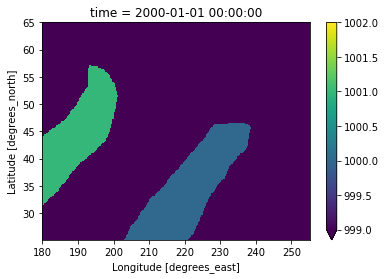

In [22]:
event_masks.isel(time=0).plot(vmin=999, vmax=1002);

In [24]:
%%time
event_masks = track_events(cnet_hist_rcp26) # generate masks with event IDs

identifying connected components..
tracking components across time..


100%|██████████| 43800/43800 [1:03:13<00:00, 11.54it/s]


num TCs: 1157
num ARs: 1830
CPU times: user 59min 22s, sys: 6min 44s, total: 1h 6min 6s
Wall time: 1h 29min 45s


In [9]:
%%time
event_masks_rcp85 = track_events(cnet_rcp85)

identifying connected components..
tracking components across time..


100%|██████████| 43800/43800 [56:39<00:00, 12.89it/s]  


num TCs: 1190
num ARs: 1893
CPU times: user 56min 9s, sys: 5min 14s, total: 1h 1min 24s
Wall time: 1h 17min 58s


### Save event masks

In [ ]:
event_masks.to_netcdf('/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/track/event_masks.nc')

In [11]:
%%time
event_masks_rcp85.to_netcdf('/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/track/event_masks.nc')

CPU times: user 416 ms, sys: 2.96 s, total: 3.37 s
Wall time: 14.4 s


## Analyze events

### Read in event masks

In [3]:
event_masks = xr.open_dataarray('/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/track/event_masks.nc', chunks={'time':500})

In [4]:
event_masks

<xarray.DataArray (time: 43800, lat: 213, lon: 433)>
dask.array<open_dataset-f915dd36526fe23f7f383b0931602c0d__xarray_dataarray_variable__, shape=(43800, 213, 433), dtype=int64, chunksize=(500, 213, 433), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 120.0 120.3 120.6 120.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 15.14 15.37 15.61 15.84 ... 64.19 64.42 64.65 64.89
  * time     (time) object 2000-01-01 00:00:00 ... 2014-12-31 21:00:00
Attributes:
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    remap_hostname:             crhtc10
    remap_version:              4.7.9
    NCO:                        netCDF Operators version 4.7.9 (Homepage = ht...
    map_file:                   /glade/campaign/cgd/amp/jet/ClimateNet/data_p...
    input_file:                 /glade/campaign/cgd/ccr/jet/nanr_forKatie/3hr...
    np:                         4
    ne:                         120
    case:                       b.e13.B20TRC5CN.ne120_g16.003
    title:                      UNSET
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

### Set save directory for plots

In [12]:
#save_dir = '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2000/masks_unwgt/' # year 2000 test data
#save_dir = '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/' # CESM historical 2000-2005
#save_dir = '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/' # CESM historical 2000-2014
save_dir = '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/' # CESM RCP8.5 2086-2100

### TO DO
* modify for ARs only (increase efficiency?)
* increase CPU and mem (looking at past job stats)
* Possible bug in longitude code? See https://github.com/andregraubner/ClimateNet/issues/19 (Line 34 should be -180?)
* Figure out why map plots for regions are coming out weird
* Save TC variables?
### Notes
* One year of test data took 3min 53s
* 5/1/25: Full historical (6 years) with batch specification as above
  * went through but failed on error related to global frequency maps, didn't record time
* 5/14/25: 14-yr historical as above with previously computed and saved `event_masks`
  * Job using all the memory/CPU
  * Walltime 27min 52s
* 5/14/25: 14-yr RCP8.5 as above
  * Walltime 28min 13s

calculating centroids..
extracting event types..
calculating genesis and termination frequencies..
generating histograms..
generating frequency maps..
CPU times: user 1min 4s, sys: 7min 47s, total: 8min 52s
Wall time: 27min 52s


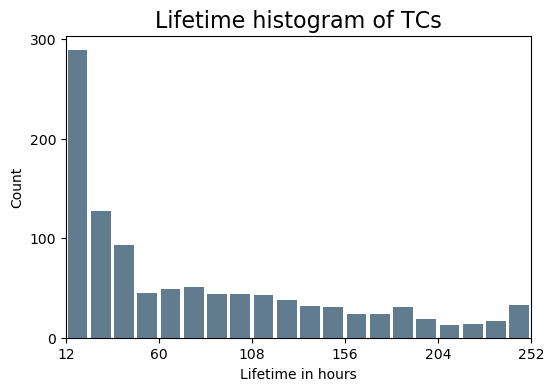

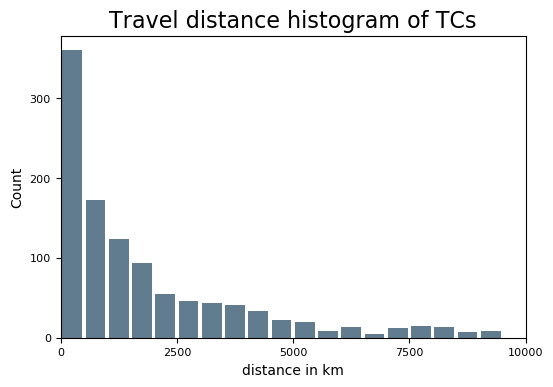

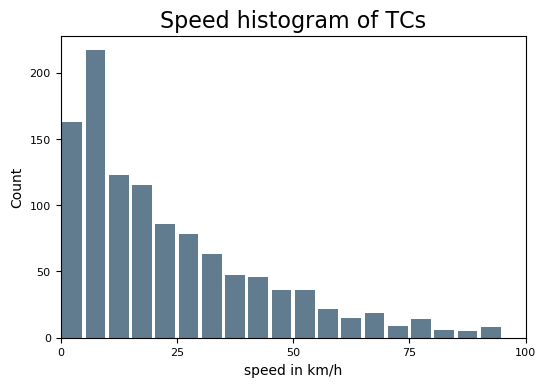

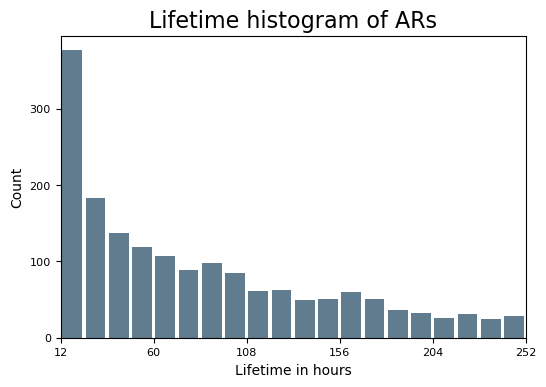

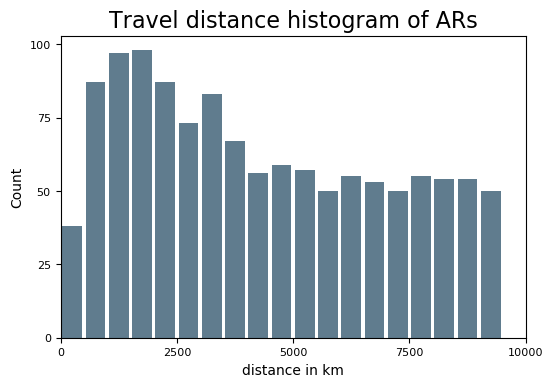

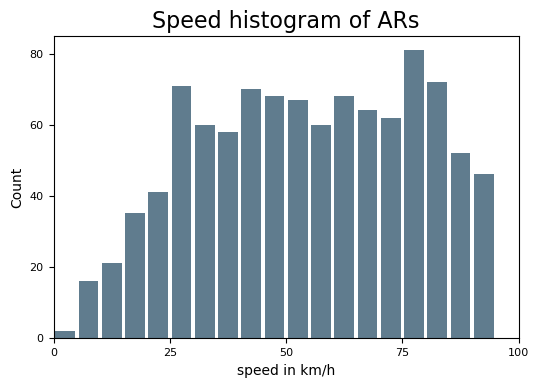

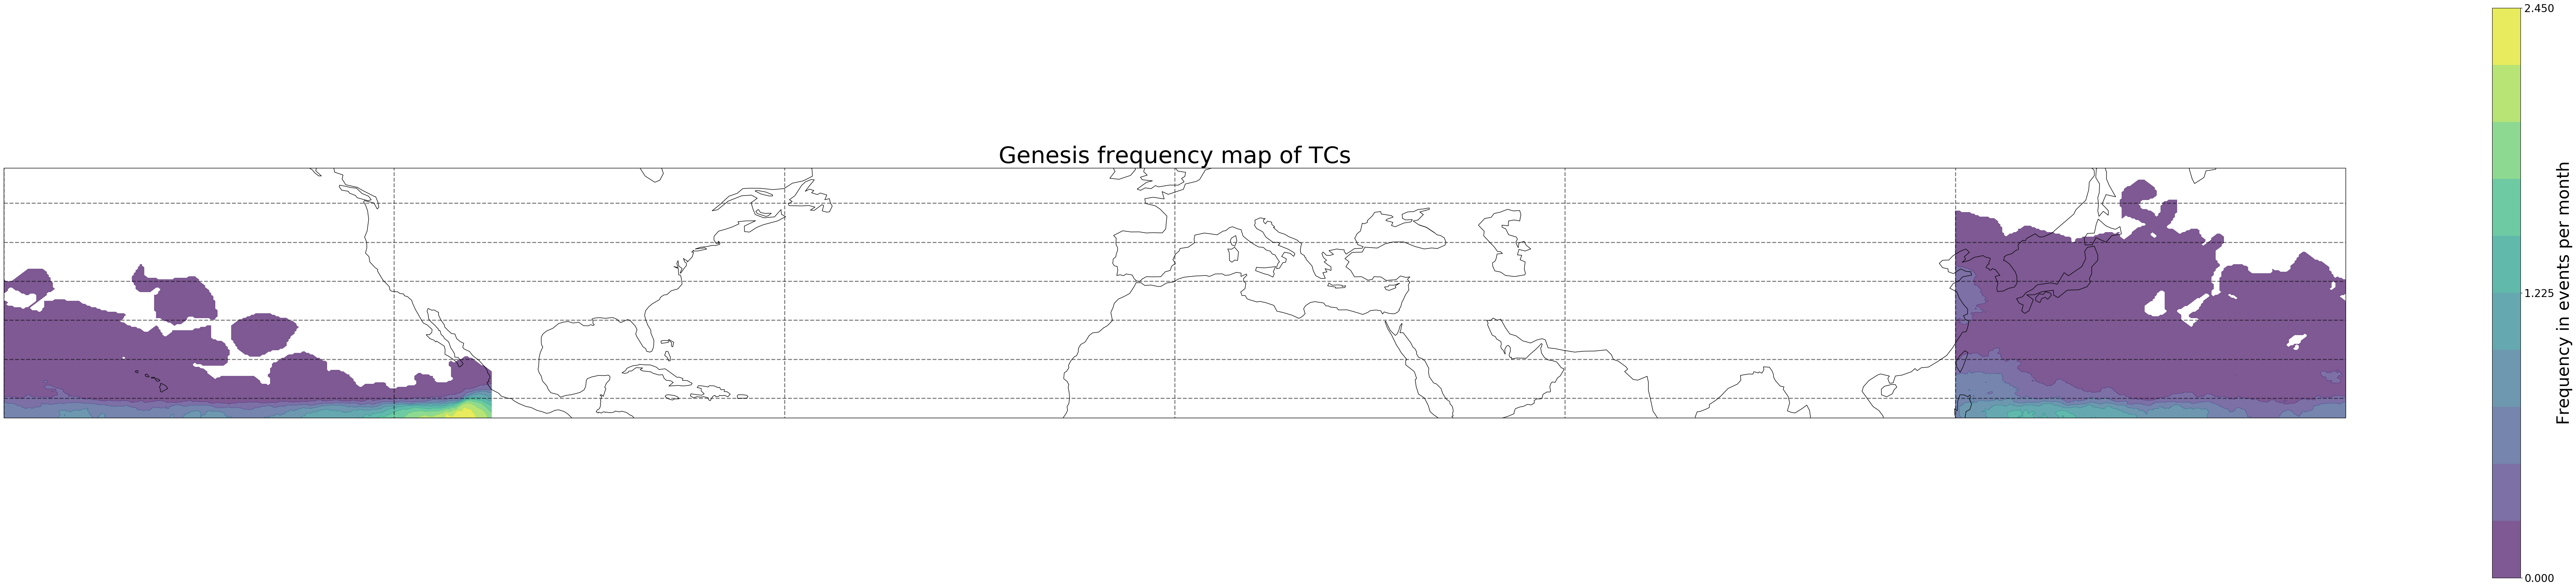

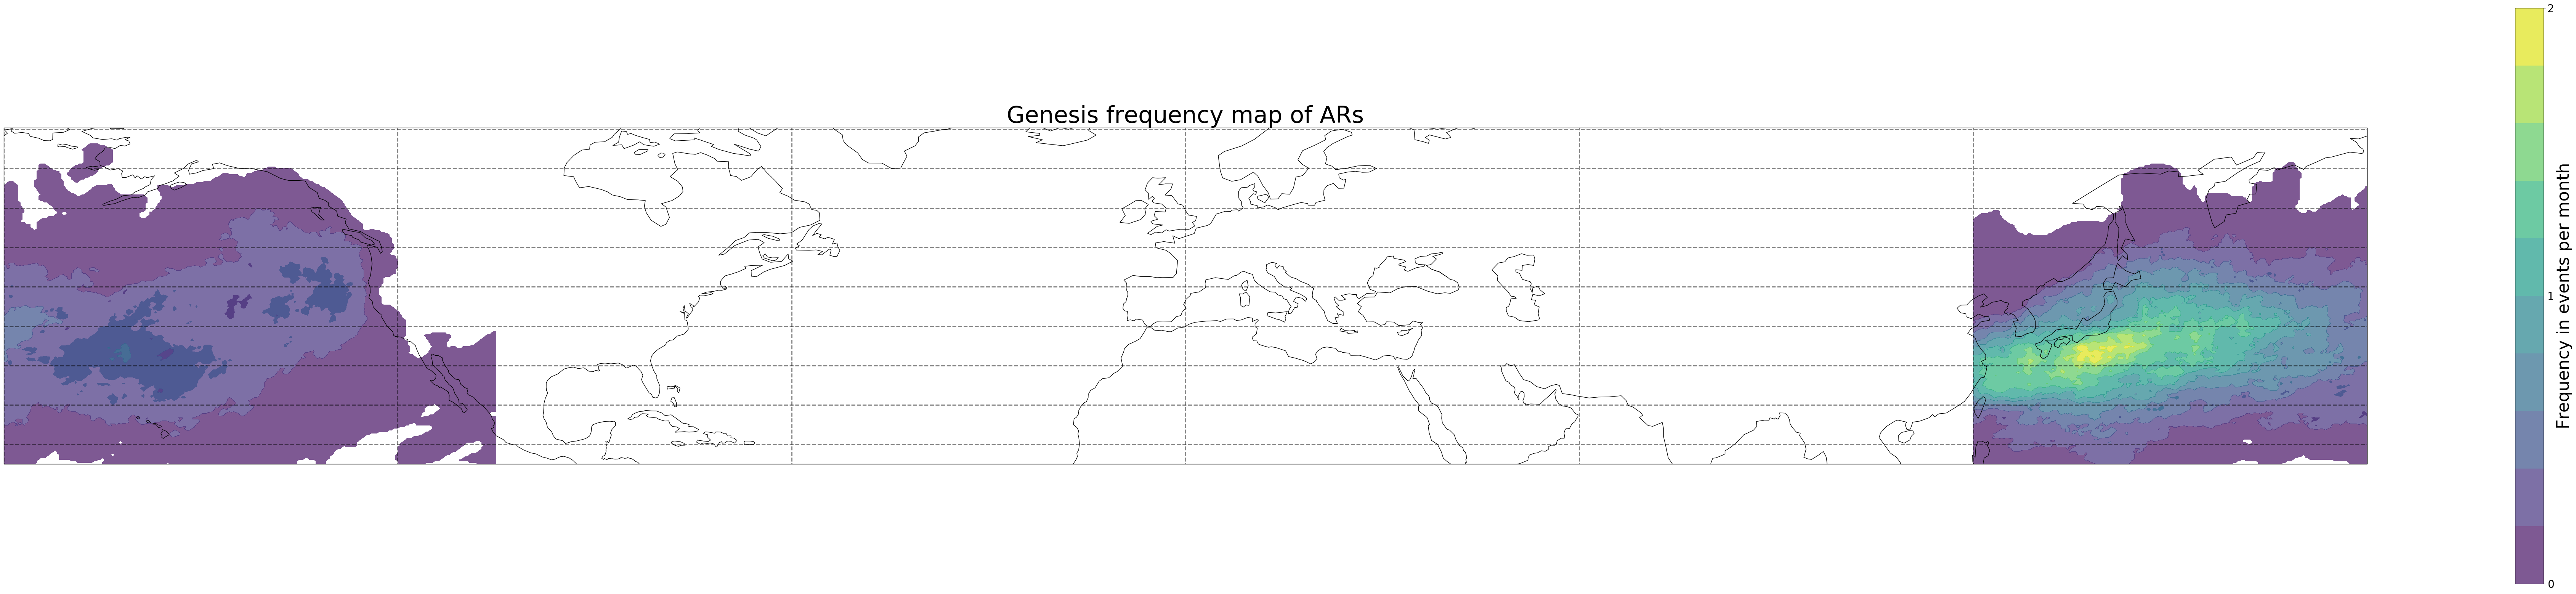

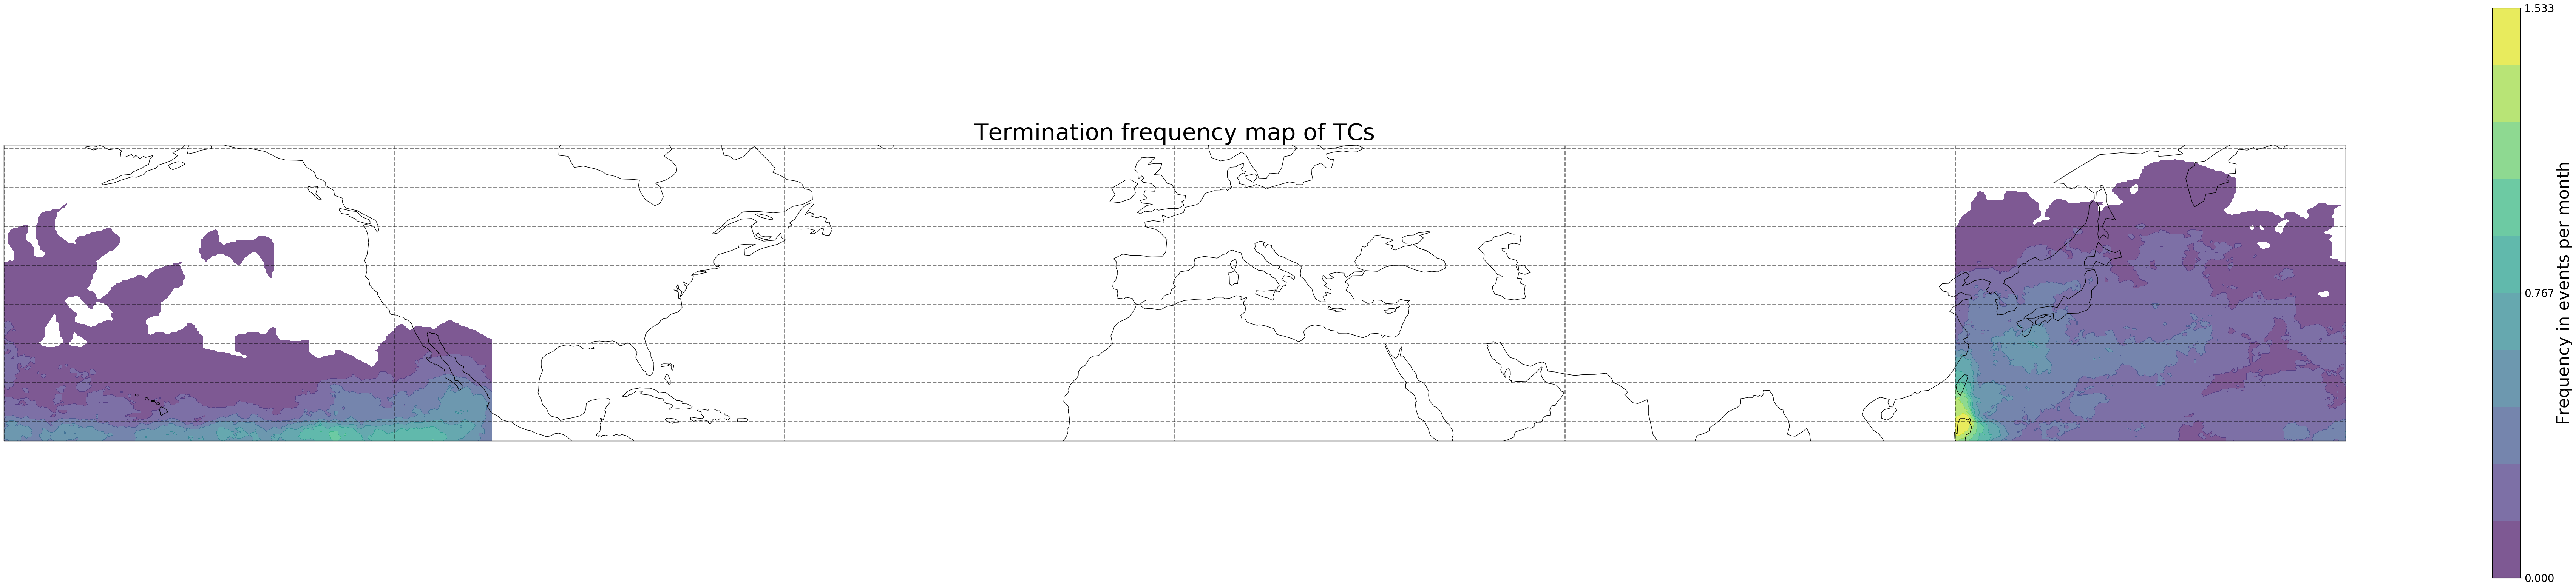

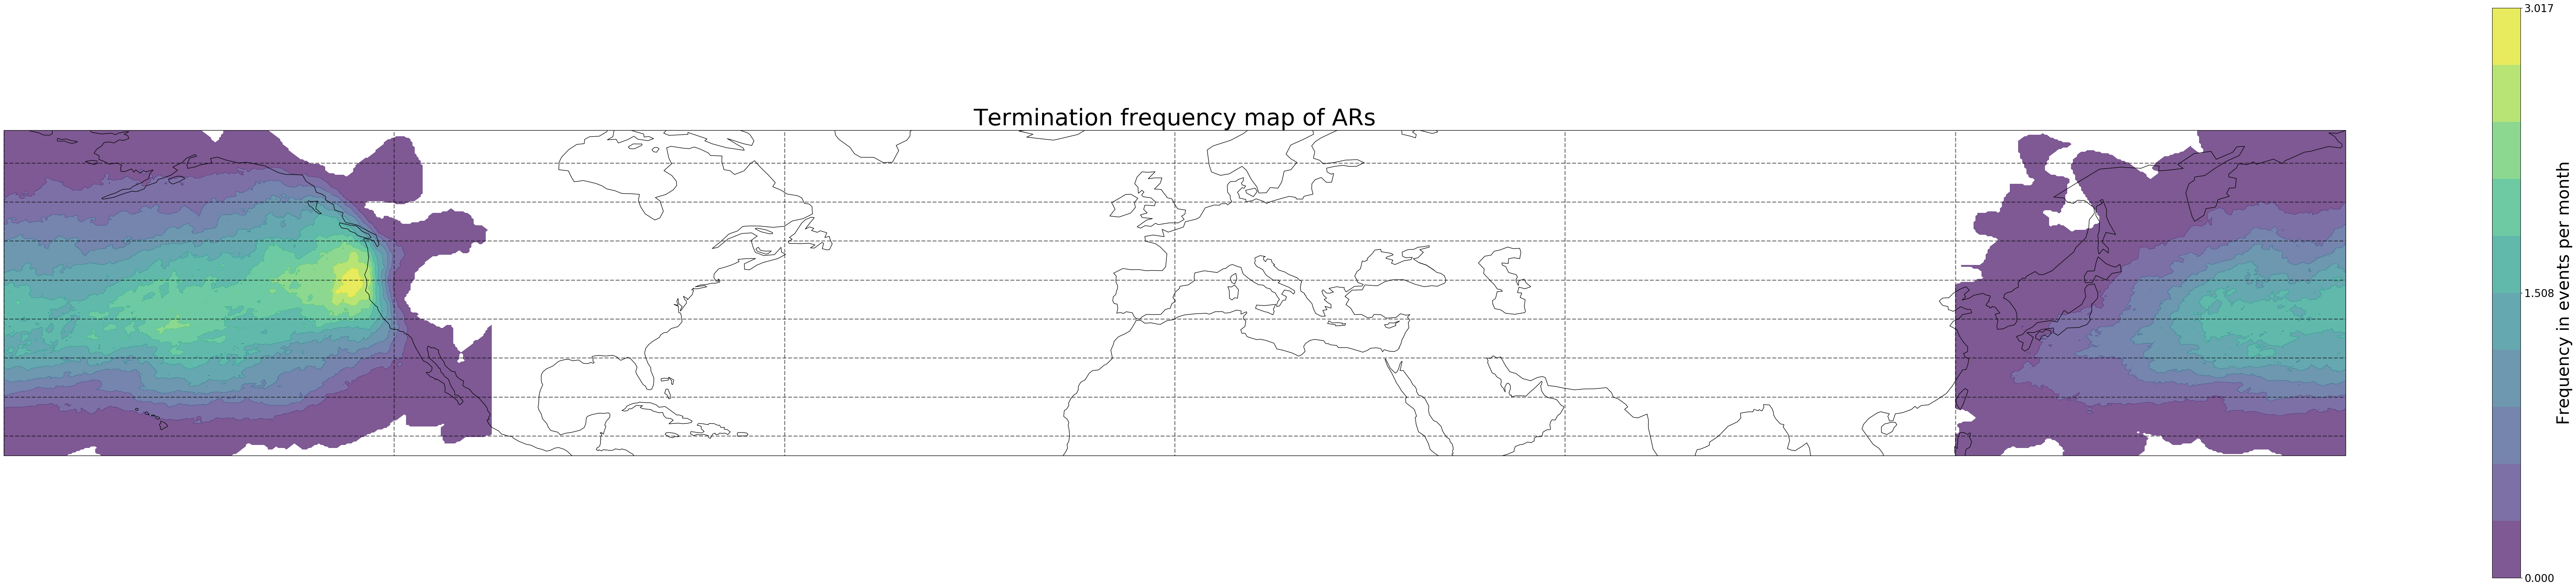

In [20]:
%%time
#analyze_events(event_masks, test_2000_masks, save_dir+'analyze/')
#genesis_frequency_ar, genesis_frequency_tc, termination_frequency_ar, termination_frequency_tc = analyze_events(event_masks, cnet_hist, save_dir+'analyze/')
lifetimes, distances, genesis_frequency_ar, genesis_frequency_tc, termination_frequency_ar, termination_frequency_tc = analyze_events(event_masks, cnet_hist_rcp26, save_dir+'analyze/')

In [21]:
# these are not indexed by time (freq per month)
genesis_frequency_ar.shape

(213, 433)

In [25]:
print(genesis_frequency_ar.min(), genesis_frequency_ar.max())
print(termination_frequency_ar.min(), termination_frequency_ar.max())

0.0 2.0
0.0 3.0166666666666666


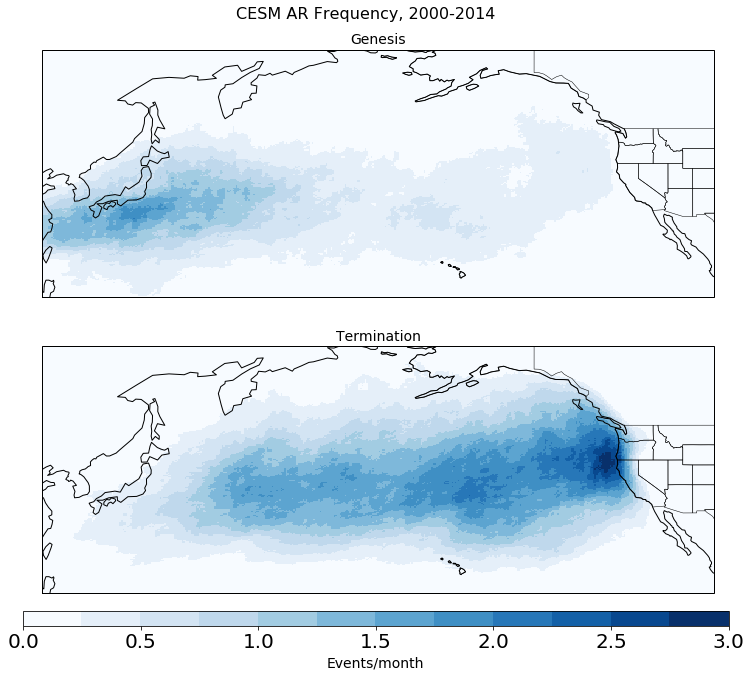

In [43]:
# side-by-side genesis and termination plots with better projection
fig, axs = plt.subplots(2, 1, figsize=(14,10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})

axs = axs.ravel()

# discrete colormap
cmap=plt.cm.get_cmap('Blues', 12) # ARTMIP region

# genesis (use event_masks for coordinates)
field, lon = add_cyclic_point(genesis_frequency_ar, coord=event_masks.lon)
lat = event_masks.lat
cf = axs[0].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=3, transform=ccrs.PlateCarree())
axs[0].coastlines(zorder=1)
axs[0].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
axs[0].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())
axs[0].set_title('Genesis', fontsize=14)

# termination
field, lon = add_cyclic_point(termination_frequency_ar, coord=event_masks.lon)
cf = axs[1].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=3, transform=ccrs.PlateCarree())
axs[1].coastlines(zorder=1)
axs[1].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
axs[1].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())
axs[1].set_title('Termination', fontsize=14)

# add colorbar
cb_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02])
cbar = plt.colorbar(cf, cax=cb_ax, orientation='horizontal')
cbar.ax.set_xlabel('Events/month', fontsize=14)

# add title
fig.suptitle('CESM AR Frequency, 2000-2014', fontsize=16, y=0.94)

#plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('../figures/toSCP/ARgenterm_CESM_hist.png', bbox_inches='tight')

### RCP8.5

calculating centroids..
extracting event types..
calculating genesis and termination frequencies..
generating histograms..
generating frequency maps..
CPU times: user 1min 9s, sys: 10min 1s, total: 11min 10s
Wall time: 28min 13s


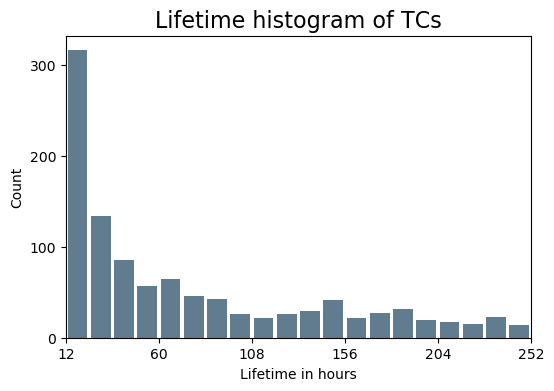

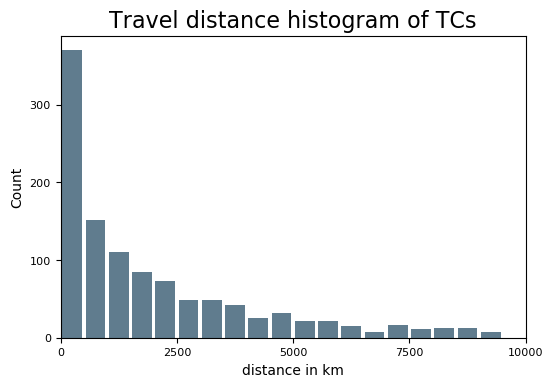

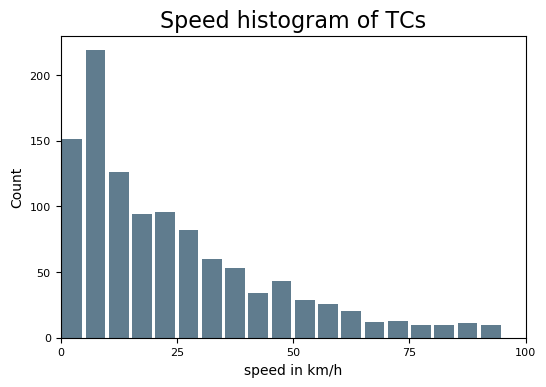

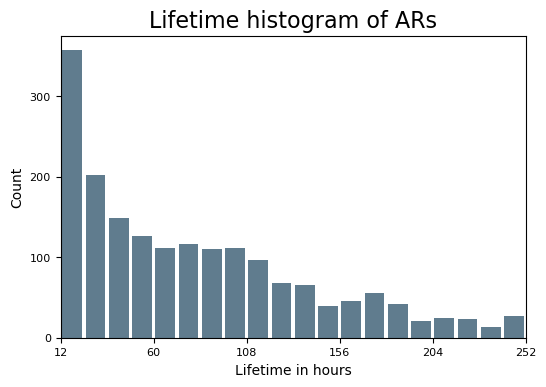

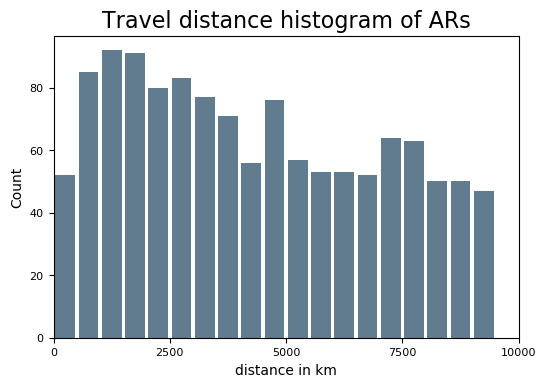

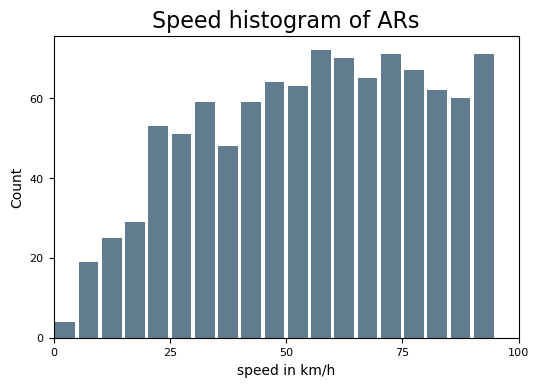

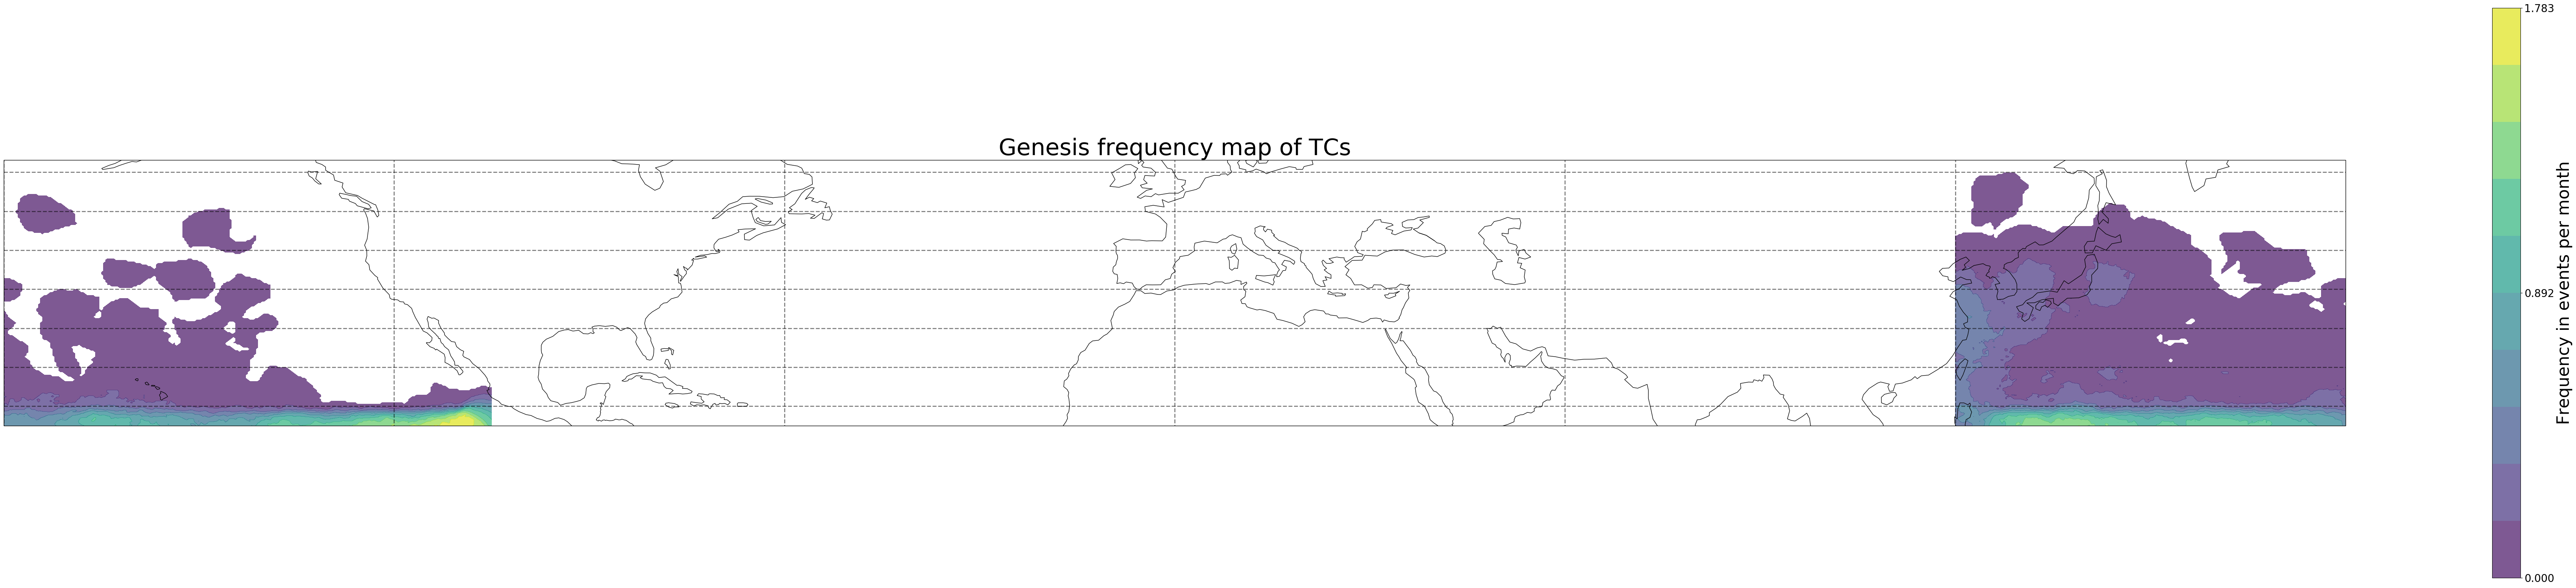

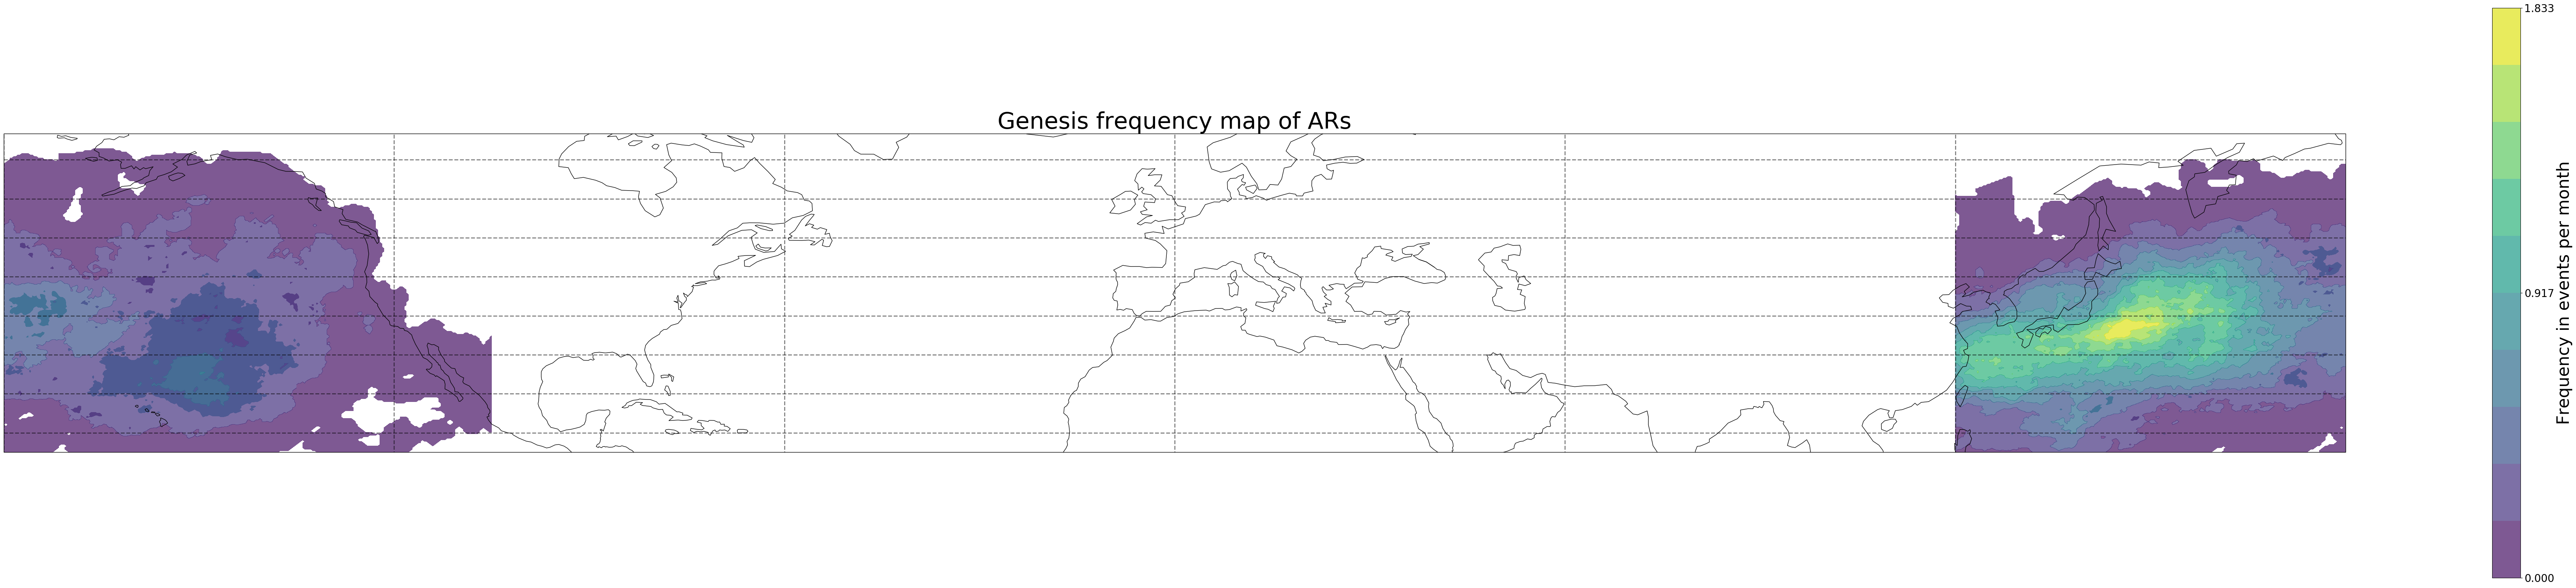

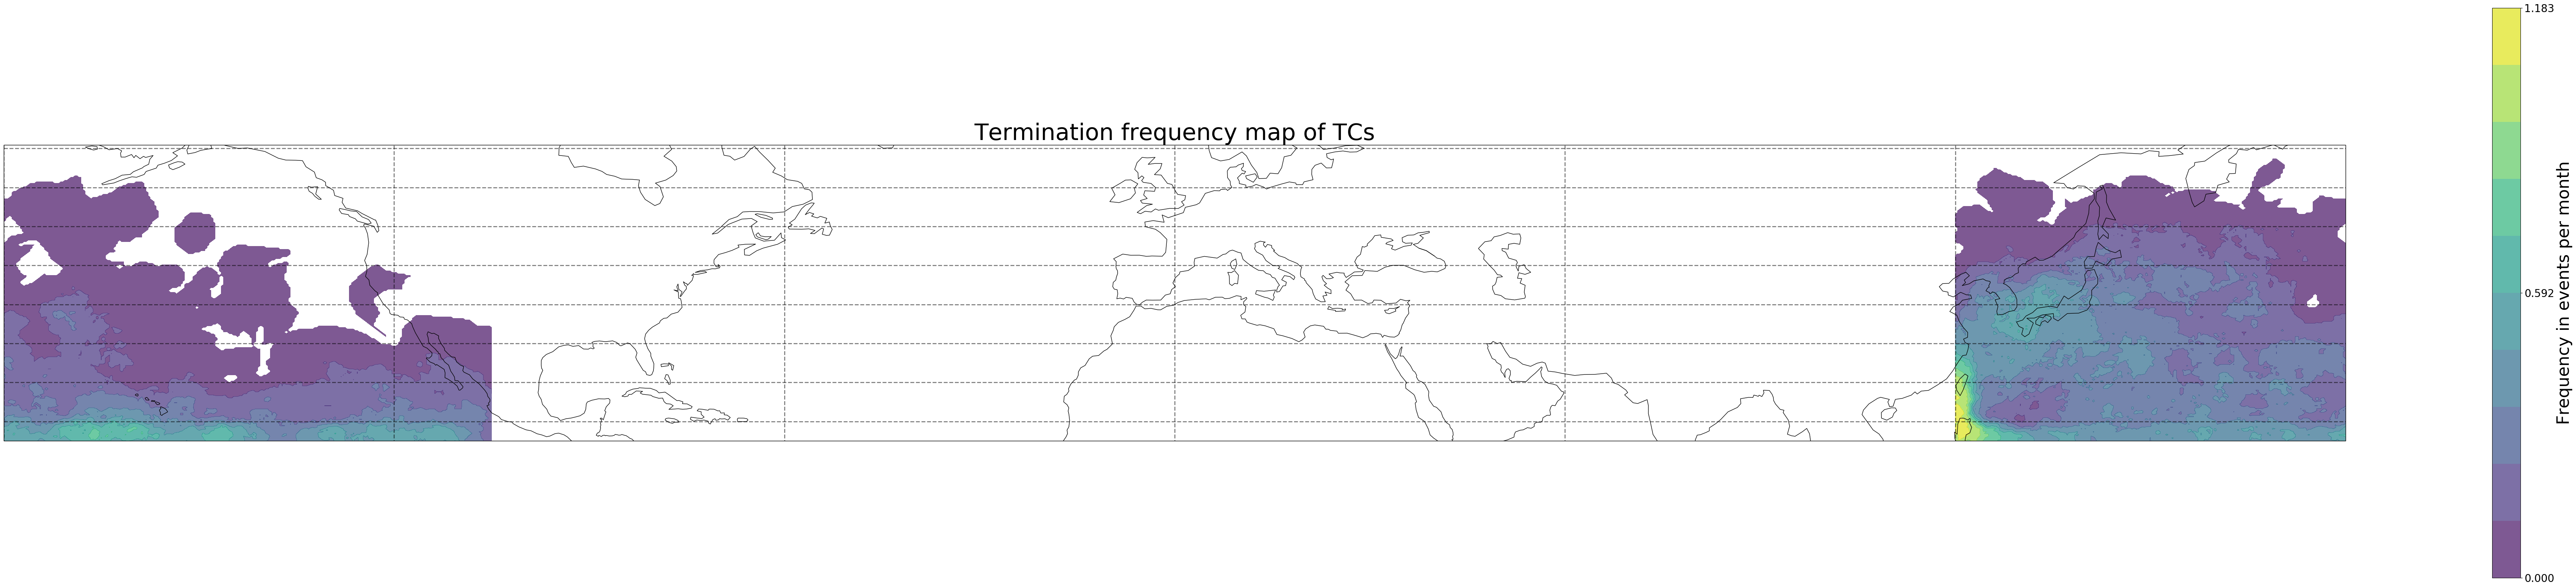

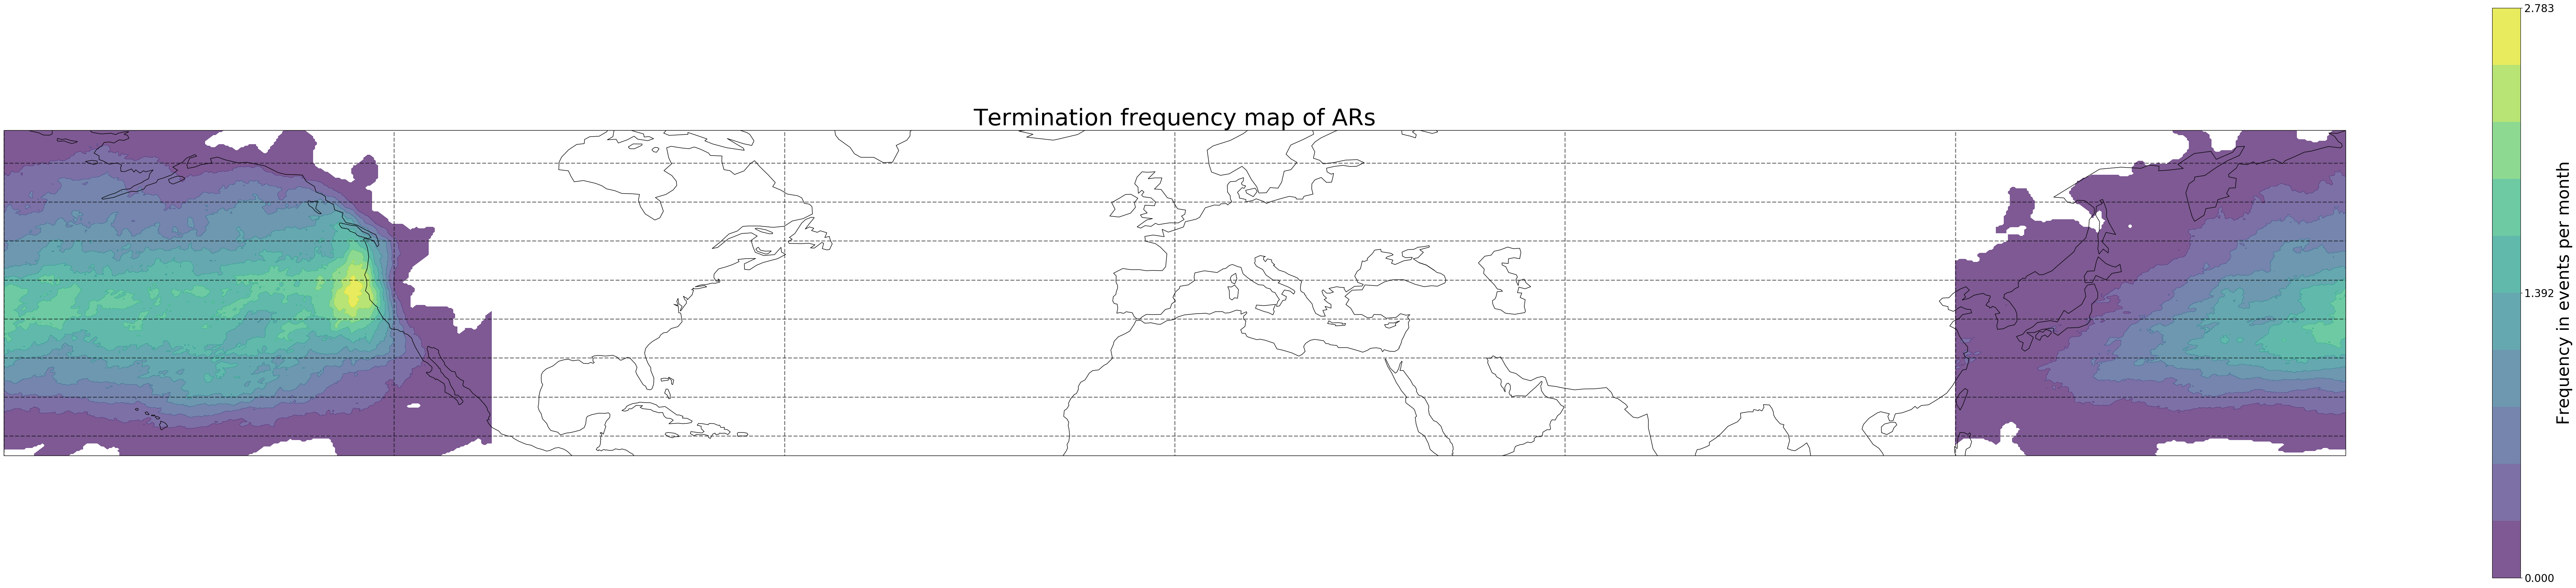

In [14]:
%%time
lifetimes, distances, genesis_frequency_ar, genesis_frequency_tc, termination_frequency_ar, termination_frequency_tc = analyze_events(event_masks_rcp85, cnet_rcp85, save_dir+'analyze/')

In [15]:
print(genesis_frequency_ar.min(), genesis_frequency_ar.max())
print(termination_frequency_ar.min(), termination_frequency_ar.max())

0.0 1.8333333333333333
0.0 2.783333333333333


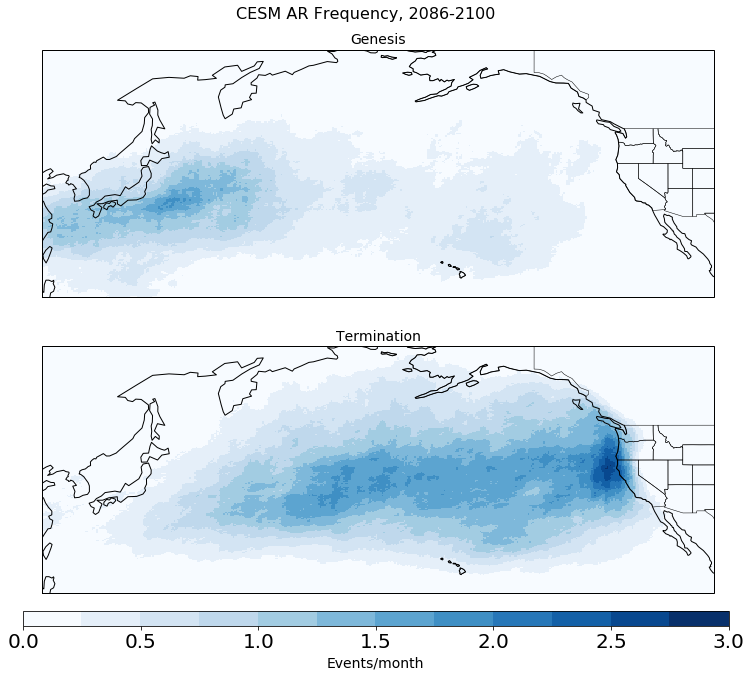

In [17]:
# side-by-side genesis and termination plots with better projection
fig, axs = plt.subplots(2, 1, figsize=(14,10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})

axs = axs.ravel()

# discrete colormap
cmap=plt.cm.get_cmap('Blues', 12) # ARTMIP region

# genesis (use event_masks for coordinates)
field, lon = add_cyclic_point(genesis_frequency_ar, coord=event_masks_rcp85.lon)
lat = event_masks_rcp85.lat
cf = axs[0].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=3, transform=ccrs.PlateCarree())
axs[0].coastlines(zorder=1)
axs[0].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
axs[0].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())
axs[0].set_title('Genesis', fontsize=14)

# termination
field, lon = add_cyclic_point(termination_frequency_ar, coord=event_masks_rcp85.lon)
cf = axs[1].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=3, transform=ccrs.PlateCarree())
axs[1].coastlines(zorder=1)
axs[1].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
axs[1].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())
axs[1].set_title('Termination', fontsize=14)

# add colorbar
cb_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02])
cbar = plt.colorbar(cf, cax=cb_ax, orientation='horizontal')
cbar.ax.set_xlabel('Events/month', fontsize=14)

# add title
fig.suptitle('CESM AR Frequency, 2086-2100', fontsize=16, y=0.94)

#plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('../figures/toSCP/ARgenterm_CESM_rcp85.png', bbox_inches='tight')

### Check histograms before saving out variables

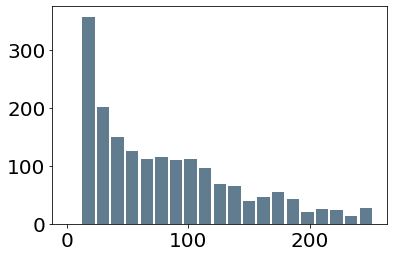

In [18]:
plt.hist(3 * lifetimes, bins = np.arange(0, 264, 12),
                cumulative=0, rwidth=0.85, color='#607c8e'); # multiplied by 3 to get result in hours

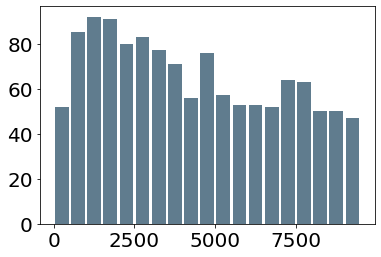

In [19]:
plt.hist(distances, bins = np.arange(0, 10000, 500),
                rwidth=0.85, color='#607c8e');

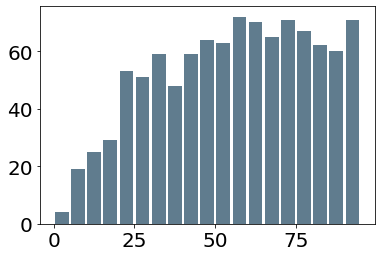

In [20]:
plt.hist(distances / (3 * lifetimes), bins = np.arange(0, 100, 5),
                rwidth=0.85, color='#607c8e'); # multiplied by 3 to get result in km/h)

### Create a dataset to store results of analyze script
Note that only AR lifetimes/distances are saved out in the modified analyze_events script because of the looping through event types

In [21]:
analysis = xr.Dataset({"lifetimes": xr.DataArray(lifetimes, dims=("events")), "distances": xr.DataArray(distances, dims=("events")), 
                       "genesis": xr.DataArray(genesis_frequency_ar, dims=("lat", "lon"), coords={"lat": event_masks_rcp85.lat, "lon": event_masks_rcp85.lon}),
                       "termination": xr.DataArray(termination_frequency_ar, dims=("lat", "lon"), coords={"lat": event_masks_rcp85.lat, "lon": event_masks_rcp85.lon})})
#analysis.attrs["notes"] = "CESM Historical, 2000-2014"
analysis.attrs["notes"] = "CESM RCP8.5, 2086-2100"
analysis

<xarray.Dataset>
Dimensions:      (events: 1893, lat: 213, lon: 433)
Coordinates:
  * lat          (lat) float64 15.14 15.37 15.61 15.84 ... 64.42 64.65 64.89
  * lon          (lon) float64 120.0 120.3 120.6 120.9 ... 254.4 254.7 255.0
Dimensions without coordinates: events
Data variables:
    lifetimes    (events) int64 38 52 11 75 30 37 48 13 ... 42 30 35 5 44 27 26
    distances    (events) float64 7.905e+03 1.675e+04 ... 2.486e+03 4.916e+03
    genesis      (lat, lon) float64 0.1833 0.1667 0.15 0.15 ... 0.0 0.0 0.0 0.0
    termination  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    notes:    CESM RCP8.5, 2086-2100

In [22]:
analysis.lifetimes

<xarray.DataArray 'lifetimes' (events: 1893)>
array([38, 52, 11, ..., 44, 27, 26])
Dimensions without coordinates: events

(array([1.446e+03, 3.520e+02, 7.500e+01, 1.400e+01, 3.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  4. ,  43.8,  83.6, 123.4, 163.2, 203. , 242.8, 282.6, 322.4,
        362.2, 402. ]),
 <a list of 10 Patch objects>)

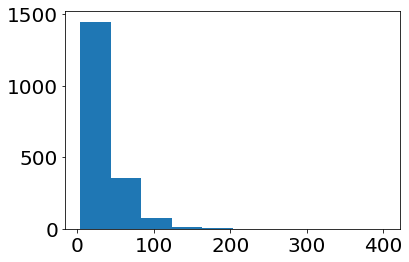

In [23]:
plt.hist(analysis.lifetimes);

In [24]:
analysis.distances

<xarray.DataArray 'distances' (events: 1893)>
array([ 7905.35516894, 16746.79813819,  5648.05829791, ...,
       11456.94356825,  2485.55634486,  4916.02148023])
Dimensions without coordinates: events

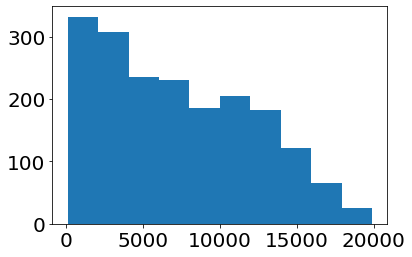

In [25]:
plt.hist(analysis.distances);

### Save out variables

In [26]:
save_dir

'/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/'

In [27]:
%%time
analysis.to_netcdf(save_dir+'analyze/AR_analysis.nc')

CPU times: user 5.28 ms, sys: 16.4 ms, total: 21.7 ms
Wall time: 176 ms


## Plotting

### Load previously saved output from analyze script

In [4]:
analysis = xr.open_dataset(cesm_cnet_filepath+'BRCP26C5CN/analyze/AR_analysis.nc')
analysis

<xarray.Dataset>
Dimensions:      (events: 1830, lat: 213, lon: 433)
Coordinates:
  * lat          (lat) float64 15.14 15.37 15.61 15.84 ... 64.42 64.65 64.89
  * lon          (lon) float64 120.0 120.3 120.6 120.9 ... 254.4 254.7 255.0
Dimensions without coordinates: events
Data variables:
    lifetimes    (events) int64 ...
    distances    (events) float64 ...
    genesis      (lat, lon) float64 ...
    termination  (lat, lon) float64 ...
Attributes:
    notes:    CESM Historical, 2000-2014

In [5]:
analysis_rcp85 = xr.open_dataset(cesm_cnet_filepath+'BRCP85C5CN/analyze/AR_analysis.nc')
analysis_rcp85

<xarray.Dataset>
Dimensions:      (events: 1893, lat: 213, lon: 433)
Coordinates:
  * lat          (lat) float64 15.14 15.37 15.61 15.84 ... 64.42 64.65 64.89
  * lon          (lon) float64 120.0 120.3 120.6 120.9 ... 254.4 254.7 255.0
Dimensions without coordinates: events
Data variables:
    lifetimes    (events) int64 ...
    distances    (events) float64 ...
    genesis      (lat, lon) float64 ...
    termination  (lat, lon) float64 ...
Attributes:
    notes:    CESM RCP8.5, 2086-2100

### Genesis/Termination heat maps and diffs

In [6]:
genesis_diff = analysis_rcp85.genesis - analysis.genesis
termination_diff = analysis_rcp85.termination - analysis.termination

In [7]:
print(genesis_diff.min().values, genesis_diff.max().values)
print(termination_diff.min().values, termination_diff.max().values)

-0.8166666666666667 0.55
-0.9166666666666667 0.5666666666666669


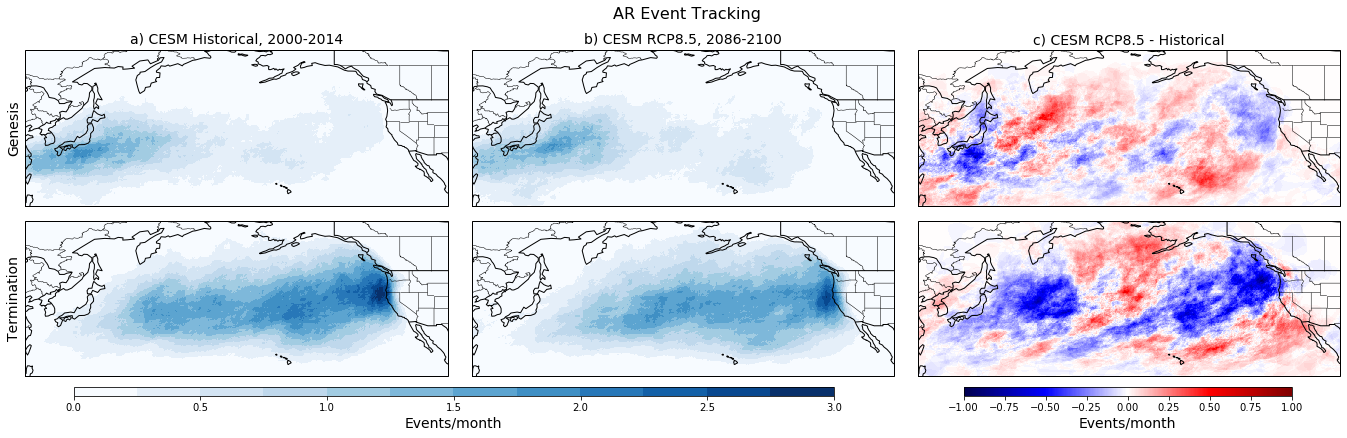

In [27]:
fig, axs = plt.subplots(2, 3, figsize=(24,6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})

#axs = axs.ravel()

# discrete colormap
cmap=plt.cm.get_cmap('Blues', 12)

# diff colormap
cmap2=plt.cm.get_cmap('seismic')

# states feature
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

# genesis hist
field, lon = add_cyclic_point(analysis.genesis, coord=analysis.lon)
lat = analysis.lat
cf = axs[0,0].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=3, transform=ccrs.PlateCarree())
axs[0,0].coastlines(zorder=1)
axs[0,0].add_feature(cfeature.BORDERS, zorder=2)
#axs[0,0].add_feature(cfeature.STATES, zorder=3, linewidth=0.5)
axs[0,0].add_feature(states_provinces, zorder=3, edgecolor='black', linewidth=0.5)
axs[0,0].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())
axs[0,0].set_ylabel('Genesis', fontsize=14)
axs[0,0].set_yticks([])
axs[0,0].set_title('a) CESM Historical, 2000-2014', fontsize=14)

# termination hist
field, lon = add_cyclic_point(analysis.termination, coord=analysis.lon)
cf = axs[1,0].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=3, transform=ccrs.PlateCarree())
axs[1,0].coastlines(zorder=1)
axs[1,0].add_feature(cfeature.BORDERS, zorder=2)
#axs[1,0].add_feature(cfeature.STATES, zorder=3, linewidth=0.5)
axs[1,0].add_feature(states_provinces, zorder=3, edgecolor='black', linewidth=0.5)
axs[1,0].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())
axs[1,0].set_ylabel('Termination', fontsize=14)
axs[1,0].set_yticks([])

# genesis rcp
field, lon = add_cyclic_point(analysis_rcp85.genesis, coord=analysis.lon)
cf = axs[0,1].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=3, transform=ccrs.PlateCarree())
axs[0,1].coastlines(zorder=1)
axs[0,1].add_feature(cfeature.BORDERS, zorder=2)
#axs[0,1].add_feature(cfeature.STATES, zorder=3, linewidth=0.5)
axs[0,1].add_feature(states_provinces, zorder=3, edgecolor='black', linewidth=0.5)
axs[0,1].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())
axs[0,1].set_title('b) CESM RCP8.5, 2086-2100', fontsize=14)

# termination rcp
field, lon = add_cyclic_point(analysis_rcp85.termination, coord=analysis.lon)
cf = axs[1,1].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=3, transform=ccrs.PlateCarree())
axs[1,1].coastlines(zorder=1)
axs[1,1].add_feature(cfeature.BORDERS, zorder=2)
#axs[1,1].add_feature(cfeature.STATES, zorder=3, linewidth=0.5)
axs[1,1].add_feature(states_provinces, zorder=3, edgecolor='black', linewidth=0.5)
axs[1,1].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add colorbar for absolute plots
cb_ax = fig.add_axes([0.16, 0.08, 0.44, 0.02])
cbar = plt.colorbar(cf, cax=cb_ax, orientation='horizontal')
cbar.ax.set_xlabel('Events/month', fontsize=14)

# genesis diff
field, lon = add_cyclic_point(genesis_diff, coord=analysis.lon)
cf = axs[0,2].pcolormesh(lon, lat, field, cmap=cmap2, vmin=-1, vmax=1, transform=ccrs.PlateCarree())
axs[0,2].coastlines(zorder=1)
axs[0,2].add_feature(cfeature.BORDERS, zorder=2)
#axs[0,2].add_feature(cfeature.STATES, zorder=3, linewidth=0.5)
axs[0,2].add_feature(states_provinces, zorder=3, edgecolor='black', linewidth=0.5)
axs[0,2].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())
axs[0,2].set_title('c) CESM RCP8.5 - Historical', fontsize=14)

# termination diff
field, lon = add_cyclic_point(termination_diff, coord=analysis.lon)
cf = axs[1,2].pcolormesh(lon, lat, field, cmap=cmap2, vmin=-1, vmax=1, transform=ccrs.PlateCarree())
axs[1,2].coastlines(zorder=1)
axs[1,2].add_feature(cfeature.BORDERS, zorder=2)
#axs[1,2].add_feature(cfeature.STATES, zorder=3, linewidth=0.5)
axs[1,2].add_feature(states_provinces, zorder=3, edgecolor='black', linewidth=0.5)
axs[1,2].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add colorbar for diff plots
cb_ax = fig.add_axes([0.675, 0.08, 0.19, 0.02])
cbar = plt.colorbar(cf, cax=cb_ax, orientation='horizontal')
cbar.ax.set_xlabel('Events/month', fontsize=14)

# add title
fig.suptitle('AR Event Tracking', fontsize=16, y=0.98, x=0.515);

plt.subplots_adjust(wspace=0, hspace=0.1)

#plt.savefig('../figures/toSCP/ARgenterm_CESM_rcp85_diff.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/ARgenterm_CESM_rcp85_diff_v2.png', dpi=600, bbox_inches='tight')

### Histograms

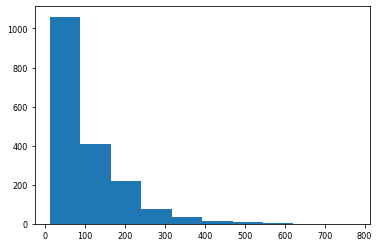

In [50]:
plt.hist(3*analysis.lifetimes);

In [127]:
# lifetime bins
np.arange(12, 180, 12)

array([ 12,  24,  36,  48,  60,  72,  84,  96, 108, 120, 132, 144, 156,
       168])

In [130]:
# lifetime xlabels
np.arange(12, 180, 12)

array([ 12,  24,  36,  48,  60,  72,  84,  96, 108, 120, 132, 144, 156,
       168])

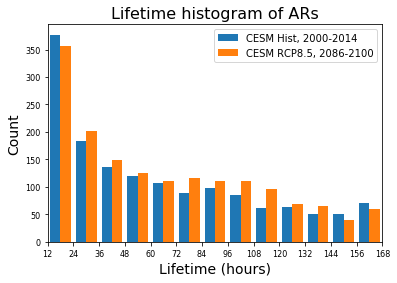

In [133]:
plt.hist([3 * analysis.lifetimes, 3 * analysis_rcp85.lifetimes], bins = np.arange(12, 180, 12)); # multiplied by 3 to get result in hours; custom bins
plt.title("Lifetime histogram of ARs", fontsize=16)
plt.xlabel("Lifetime (hours)", fontsize=14)
plt.xticks(np.arange(12, 180, 12))
plt.xlim(12, 168)
plt.ylabel("Count", fontsize=14)
plt.legend(['CESM Hist, 2000-2014', 'CESM RCP8.5, 2086-2100']);

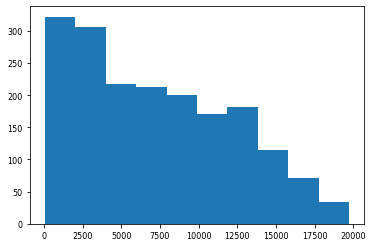

In [83]:
plt.hist(analysis.distances);

In [141]:
# distance bins
np.arange(0, 19500, 1500)

array([    0,  1500,  3000,  4500,  6000,  7500,  9000, 10500, 12000,
       13500, 15000, 16500, 18000])

In [148]:
# distance x labels
np.arange(0, 18001, 3000)

array([    0,  3000,  6000,  9000, 12000, 15000, 18000])

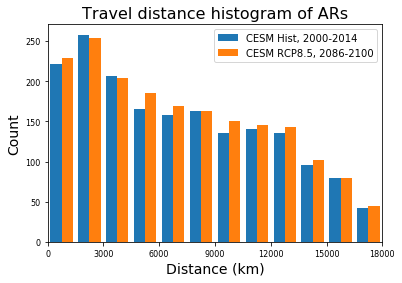

In [149]:
plt.hist([analysis.distances, analysis_rcp85.distances], bins = np.arange(0, 19500, 1500)); # custom bins
plt.title("Travel distance histogram of ARs", fontsize=16)
plt.xlabel("Distance (km)", fontsize=14)
plt.xticks(np.arange(0, 18001, 3000))
plt.xlim(0, 18000)
plt.ylabel("Count", fontsize=14)
plt.legend(['CESM Hist, 2000-2014', 'CESM RCP8.5, 2086-2100']);

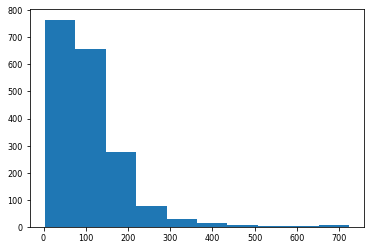

In [82]:
plt.hist(analysis.distances / (3 * analysis.lifetimes));

In [158]:
# speed bins
np.arange(0, 250, 20)

array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240])

In [167]:
# speed x labels
np.arange(0, 241, 40)

array([  0,  40,  80, 120, 160, 200, 240])

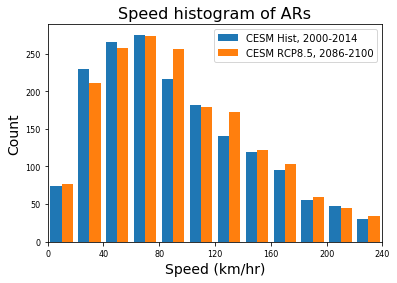

In [164]:
plt.hist([analysis.distances / (3 * analysis.lifetimes), analysis_rcp85.distances / (3 * analysis_rcp85.lifetimes)], bins = np.arange(0, 250, 20)); # multiplied by 3 to get result in km/hour; custom bins
plt.title("Speed histogram of ARs", fontsize=16)
plt.xlabel("Speed (km/hr)", fontsize=14)
plt.xticks(np.arange(0, 241, 40))
plt.xlim(0,240)
plt.ylabel("Count", fontsize=14)
plt.legend(['CESM Hist, 2000-2014', 'CESM RCP8.5, 2086-2100']);

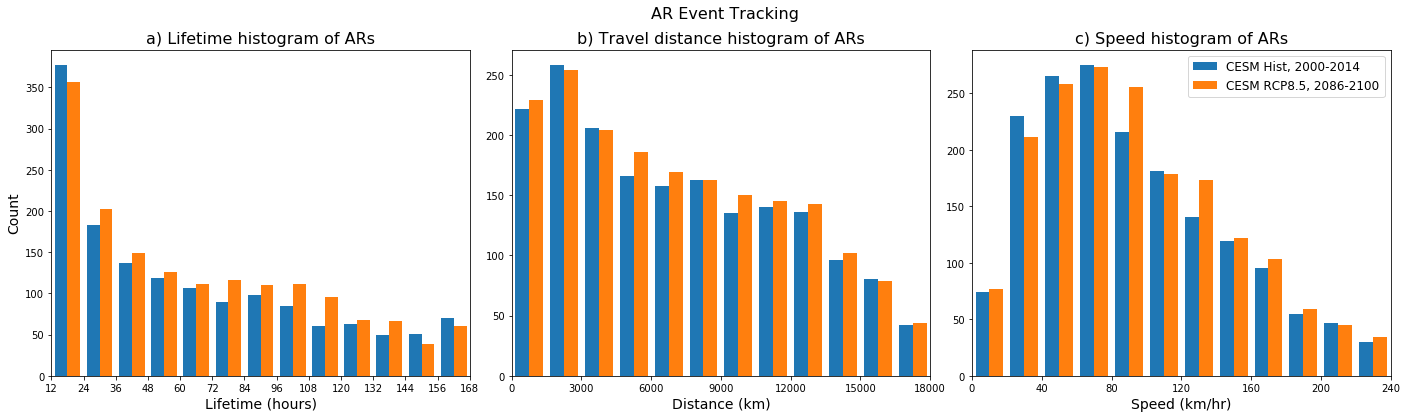

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(24,6))

# lifetime
axs[0].hist([3 * analysis.lifetimes, 3 * analysis_rcp85.lifetimes], bins = np.arange(12, 180, 12)); # multiplied by 3 to get result in hours; custom bins
axs[0].set_title("a) Lifetime histogram of ARs", fontsize=16)
axs[0].set_xlabel("Lifetime (hours)", fontsize=14)
axs[0].set_xticks(np.arange(12, 180, 12))
axs[0].set_xlim(12, 168)
axs[0].set_ylabel("Count", fontsize=14)

axs[1].hist([analysis.distances, analysis_rcp85.distances], bins = np.arange(0, 19500, 1500)); # custom bins
axs[1].set_title("b) Travel distance histogram of ARs", fontsize=16)
axs[1].set_xlabel("Distance (km)", fontsize=14)
axs[1].set_xticks(np.arange(0, 18001, 3000))
axs[1].set_xlim(0, 18000)

axs[2].hist([analysis.distances / (3 * analysis.lifetimes), analysis_rcp85.distances / (3 * analysis_rcp85.lifetimes)], bins = np.arange(0, 250, 20)); # multiplied by 3 to get result in km/hour; custom bins
axs[2].set_title("c) Speed histogram of ARs", fontsize=16)
axs[2].set_xlabel("Speed (km/hr)", fontsize=14)
axs[2].set_xticks(np.arange(0, 241, 40))
axs[2].set_xlim(0,240)
axs[2].legend(['CESM Hist, 2000-2014', 'CESM RCP8.5, 2086-2100'], fontsize=12);

# add title
fig.suptitle('AR Event Tracking', fontsize=16, y=0.98, x=0.515);

plt.subplots_adjust(wspace=0.1);

#plt.savefig('../figures/toSCP/ARhists_CESM_rcp85.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/ARhists_CESM_rcp85_v2.png', dpi=600, bbox_inches='tight')

## Visualize events

### This script needs a `ClimateDataset` with TMQ

In [14]:
model_path = '/glade/work/kdagon/ML-extremes/trained_models/trained_cgnet.040523' # unweighted means/std in config file
inference_path = '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2000/' # test year 2000

### Confirm GPU resources
Can request through JupyterHub launch page.\
Current resources request (as of 4/5/23): 1 node, 2 cpu, 64GB mem, 2 V100 GPU

In [11]:
# requires loading pytorch into environment
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
2


In [12]:
# instantiate CGNet with pre-trained model
cgnet = CGNet(model_path=model_path)

In [15]:
# inference using the pre-trained config file
inference = ClimateDataset(inference_path, cgnet.config)

In [19]:
inference.fields

{'TMQ': {'mean': 19.218494415283203, 'std': 15.817276954650879},
 'U850': {'mean': 1.5530235767364502, 'std': 8.29762077331543},
 'V850': {'mean': 0.2541317045688629, 'std': 6.231630802154541},
 'PSL': {'mean': 100814.078125, 'std': 1461.225830078125}}

In [21]:
inference.length

2920

In [29]:
inference[0].sel(variable="TMQ", lat=lat_bounds, lon=lon_bounds)[0]

<xarray.DataArray (lat: 170, lon: 241)>
array([[ 0.32455808,  0.30092496,  0.26880386, ..., -0.9406195 ,
        -0.8912217 , -0.85587865],
       [ 0.27786812,  0.25678587,  0.22858252, ..., -0.90729797,
        -0.8536453 , -0.8300588 ],
       [ 0.2401025 ,  0.21914276,  0.19865936, ..., -0.86855245,
        -0.8197885 , -0.81094086],
       ...,
       [-1.0267847 , -1.0258461 , -1.025046  , ..., -1.1119231 ,
        -1.1130844 , -1.1142647 ],
       [-1.0298895 , -1.0281522 , -1.0272939 , ..., -1.1125365 ,
        -1.1137369 , -1.1149408 ],
       [-1.0399888 , -1.0374137 , -1.0349996 , ..., -1.1133527 ,
        -1.1145583 , -1.1157688 ]], dtype=float32)
Coordinates:
  * lon       (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0
    time      object 2000-01-01 03:00:00
  * lat       (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
    variable  <U4 'TMQ'
Attributes:
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    remap_hostname:             crhtc10
    remap_version:              4.7.9
    NCO:                        netCDF Operators version 4.7.9 (Homepage = ht...
    map_file:                   /glade/campaign/cgd/amp/jet/ClimateNet/data_p...
    input_file:                 /glade/campaign/cgd/ccr/jet/nanr_forKatie/3hr...
    np:                         4
    ne:                         120
    case:                       b.e13.B20TRC5CN.ne120_g16.003
    title:                      UNSET
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

### Visualize script doesn't work out of the box
Maybe because inference is global and event_masks is not?\
With regional mods did make some pngs but they are wrong...slicing latitudes but not longitudes?\
There is also a related github issue: https://github.com/andregraubner/ClimateNet/issues/20 \
Can reference what TK is doing here for polar ARs in: `/glade/work/tking/cgnet/ML-extremes/notebooks/PolarARs` and `/glade/work/tking/cgnet/ClimateNet/climatenet`

In [30]:
%%time
visualize_events(event_masks, inference, save_dir+'visualize/')

generating images..


/glade/work/kdagon/miniconda/envs/cgnet-dask/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/glade/work/kdagon/miniconda/envs/cgnet-dask/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


IndexError: index 3 is out of bounds for axis 0 with size 1